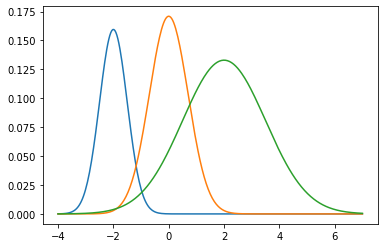

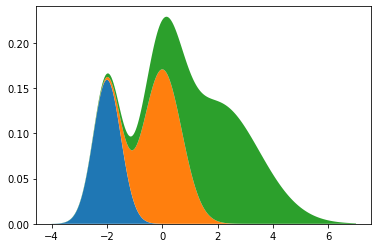

In [79]:
import numpy as np
import matplotlib.pyplot as plt

K = 3
n = 301
mu = [-2, 0 ,2]
sigma = [0.5, 0.7, 1.5]
pi = [0.2, 0.3, 0.5]
intervals = np.linspace(-4, 7, n)

pdfs = np.zeros(shape = [n, K])
mix_pdf = np.zeros(shape = [n])
for k in range(K):
  pdfs[:, k] = pi[k] * 1/(np.math.sqrt(2*np.math.pi)*sigma[k]) * np.exp(-(intervals-mu[k])**2 / (2*sigma[k]**2))
  mix_pdf += pdfs[:, k]

plt.figure()
for k in range(K):
  plt.plot(np.linspace(-4,7,n), pdfs[:, k])
plt.show()

plt.figure()
plt.stackplot(intervals, pdfs[:, 0], pdfs[:, 1], pdfs[:, 2])
plt.show()

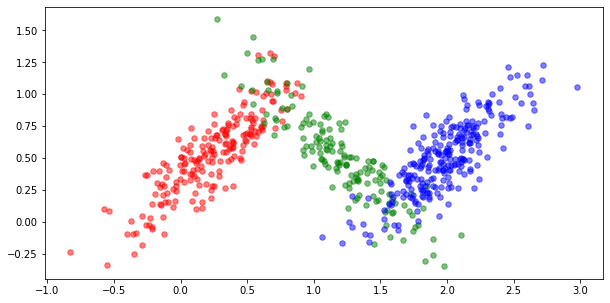

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rd
from scipy import stats as st

seed = 77
D = 2
n = [200, 150, 250]
N = np.sum(n)
mu_true = np.array([[0.2, 0.5], [1.2, 0.5], [2.0, 0.5]])
sigma_true = np.array([
      [[0.1, 0.085],[0.085, 0.1]],
      [[0.1, -0.085],[-0.085, 0.1]],
      [[0.1, 0.085],[0.085, 0.1]],
])
rd.seed(seed)
c = ["r", "g", "b", "gray"]
org_data = []
for i in range(3):
  org_data.append(np.random.multivariate_normal(mu_true[i], sigma_true[i], n[i]))

plt.figure(figsize=(10,5))
for i in range(3):
  plt.scatter(org_data[i][:, 0], org_data[i][:, 1], s = 30, c = c[i], alpha = 0.5)

data = np.zeros(shape = [np.sum(n), 2])
data[0:200, :] = org_data[0]
data[200:350, :] = org_data[1]
data[350:600, :] = org_data[2]

In [3]:
def likelihood_cal(data, mu, sigma, pi, K):
  likelihood = np.zeros(shape = [np.sum(n), K])
  for i in range(np.sum(n)):
    for k in range(K):
      d = np.array([data[i][0], data[i][1]]).T
      likelihood[i, k] = pi[k] * st.multivariate_normal.pdf(d, mu[k], sigma[k])
  return likelihood

# initialize pi
K = 3
pi = np.zeros(K)
for k in range(K):
  pi[k] = 1/K

# initialize mu
x_max, x_min = np.max(data[:, 0]), np.min(data[:, 0])
y_max, y_min = np.max(data[:, 1]), np.min(data[:, 1])
mu = np.array([rd.uniform(low = x_min, high = x_max, size = K), rd.uniform(low = y_min, high = y_max, size = K)]).T

# initialize sigma
sigma = np.array([
    [[0.1, 0], [0, 0.1]],
    [[0.1, 0], [0, 0.1]],
    [[0.1, 0], [0, 0.1]],
])
likelihood = likelihood_cal(data, mu, sigma, pi, K)
print("initial sum of log likelihood: {}".format(np.sum(np.log(likelihood))))

initial sum of log likelihood: -18447.335940290694


In [1]:
def print_gmm_contour(mu, sigma, pi, K):
  X, Y = np.meshgrid(np.linspace(x_min, x_max), np.linspace(y_min, y_max))
  XX = np.array([X.ravel(), Y.ravel()]).T
  Z = np.sum(np.array([[pi[k] * st.multivariate_normal.pdf(d, mu[k], sigma[k]) for k in range(K)] for d in XX]), axis = 1)
  Z = Z.reshape(X.shape)
  CS = plt.contour(X, Y, Z, alpha = 0.5, zorder = -100)
  plt.title("pdf contour of a GMM")

# EM iteration
def iterate(step):
  global mu, sigma, pi
  plt.clf()
  print("step: {}".format(step))
  if step <= 3:
    print("initial state")
    plt.scatter(data[:, 0], data[:, 1], s = 30, c = "gray", alpha = 0.5, marker = "+")
    for i in range(3):
      plt.scatter(mu[i, 0], mu[i, 1], c = c[i], marker = "o", edgecolors = "k", linewidths = 1)
    print_gmm_contour(mu, sigma, pi, K)
    plt.title("inital state")
    return
  
  # E step
  likelihood = likelihood_cal(data, mu, sigma, pi, K)
  gamma = (likelihood.T / np.sum(likelihood, axis = 1)).T
  N_k = [np.sum(gamma[:, k]) for k in range(K)]

  # M step
  # pi
  pi = N_k / N

  # mu
  mu_tmp = np.zeros(shape = [K, D])
  for k in range(K):
    for i in range(len(data)):
      mu_tmp[k] += gamma[i, k] * data[i]
    mu_tmp[k] /= N_k[k]
  mu_prev = mu.copy()
  mu = mu_tmp.copy()
  print("updated mu:\n{}".format(mu))

  # sigma
  sigma_tmp = np.zeros(sigma.shape)
  for k in range(K):
    for i in range(len(data)):
      sigma_tmp[k] += gamma[i, k] * np.dot((data[i] - mu[k])[:, np.newaxis], (data[i] - mu[k])[:, np.newaxis].T)
    sigma_tmp[k] /= N_k[k]
  sigma_prev = sigma.copy()
  sigma = sigma_tmp.copy()
  print("updated sigma:\n{}".format(sigma))

  # update likelihood
  sum_log_likelihood_prev = np.sum(np.log(likelihood))
  sum_log_likelihood = np.sum(np.log(likelihood_cal(data, mu, sigma, pi, K)))

  diff = sum_log_likelihood - sum_log_likelihood_prev
  print("sum log likelihood: {}".format(sum_log_likelihood))
  print("diff: {}".format(diff))

  for i in range(np.sum(n)):
    plt.scatter(data[i, 0], data[i, 1], s = 30, c = c[np.argmax(gamma[i])], alpha = 0.5, marker = "+")
  
  for k in range(K):
    ax = plt.axes()
    ax.arrow(mu_prev[k, 0], mu_prev[k, 1], mu[k, 0] - mu_prev[k, 0], mu[k, 1] - mu_prev[k, 1], lw = 0.8, head_width = 0.02, head_length = 0.02, fc = "k", ec = "k")
    plt.scatter(mu_prev[k, 0], mu_prev[k, 1], c = c[k], marker = "o", alpha = 0.8)
    plt.scatter(mu[k, 0], mu[k, 1], c = c[k], marker = "o", edgecolors = "k", linewidths = 1)
  # plt.title("steps: {}".format(step))

  print_gmm_contour(mu, sigma, pi, K)

  if np.abs(diff) < 0.0001:
    plt.title("likelihood converged")
  else:
    plt.title("step: {}".format(step))

step: 0
initial state
step: 0
initial state
step: 1
initial state
step: 2
initial state
step: 3
initial state
step: 4
updated mu:
[[0.749316   0.97552716]
 [0.62531629 0.5141778 ]
 [1.99693034 0.47893799]]
updated sigma:
[[[ 0.14374742 -0.04094105]
  [-0.04094105  0.08829181]]

 [[ 0.33820703  0.02706953]
  [ 0.02706953  0.08775767]]

 [[ 0.07559041  0.06744626]
  [ 0.06744626  0.094304  ]]]
sum log likelihood: -21453.92385793737
diff: -3006.587917646677


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


step: 5
updated mu:
[[0.70898228 0.99524023]
 [0.59550908 0.51571112]
 [1.96835627 0.46885326]]
updated sigma:
[[[ 0.06997609 -0.04117838]
  [-0.04117838  0.08125925]]

 [[ 0.33951167  0.03615401]
  [ 0.03615401  0.08410664]]

 [[ 0.08445111  0.07159854]
  [ 0.07159854  0.09257322]]]
sum log likelihood: -23066.62168657432
diff: -1612.6978286369485
step: 6
updated mu:
[[0.7107797  1.00418807]
 [0.56326307 0.50993382]
 [1.95411115 0.46195547]]
updated sigma:
[[[ 0.04848208 -0.03542566]
  [-0.03542566  0.06721159]]

 [[ 0.32881589  0.04311163]
  [ 0.04311163  0.07789325]]

 [[ 0.08954601  0.07325812]
  [ 0.07325812  0.09242933]]]
sum log likelihood: -25023.881006058335
diff: -1957.2593194840156
step: 7
updated mu:
[[0.71770994 1.00328181]
 [0.53000809 0.50477513]
 [1.94431536 0.45613919]]
updated sigma:
[[[ 0.04132627 -0.03209786]
  [-0.03209786  0.05891647]]

 [[ 0.31196499  0.05013431]
  [ 0.05013431  0.07144135]]

 [[ 0.09304103  0.07383677]
  [ 0.07383677  0.09325156]]]
sum log likeli

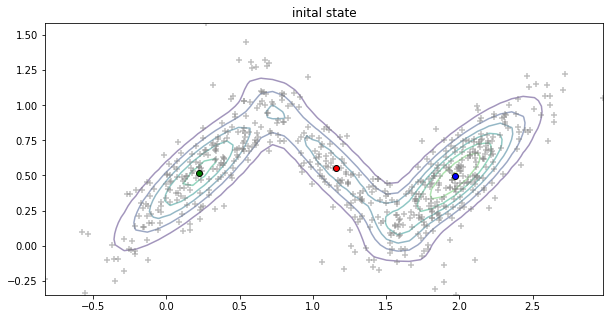

In [4]:
import matplotlib.animation as ani
fig = plt.figure(figsize=(10, 5))
anim = ani.FuncAnimation(fig, iterate, frames = 48)
anim.save("gmm.gif", writer = "pillow", fps = 3, dpi = 128)